In [ ]:
# Written by David Gontier
# 09/29/2022

# Computation of the Birman-Schwinger operator for Dirac (and Schrödinger)

In this code, we compute the spectrum of a *fixed* 2d Dirac operator, of the form $D_m - V$, with $V \ge 0$, and where
$$
    D_m = \begin{pmatrix}
        m & \partial_x - i \partial_y \\ -\partial_x - i \partial_y & -m
    \end{pmatrix}.
$$
Recall the Birmann-Schwinger principle, that $\lambda$ is an eigenvalue of $D_m - V$ iff $1$ is an eigenvalue of $K_V(\lambda)$, where
$$
    K_V(\lambda) := \sqrt{V}  R_0(\lambda) \sqrt{V}, \quad \text{with} \quad R_0(\lambda) = (D_m - \lambda)^{-1} = \dfrac{1}{-\Delta + m^2 - \lambda^2} (D_m + \lambda)
$$

In [134]:
reset

Nothing done.


In [1]:
%pylab inline
import os
import scipy.sparse.linalg as LA
import scipy.optimize as optimize

Populating the interactive namespace from numpy and matplotlib


We compute the Dirac operator (and its inverse), in Fourier space. Writing (with Python convention)
$$
    f(x) = \sum_{k=-M}^M f_k \exp ( - i k \frac{2 \pi }{2 a} x),
$$
we access the coefficients $v_k$ with `fft.fft(v)` (and some shifts), and the operator $(- i \partial_x)$ becomes the multiplication by $-\frac{\pi}{a} k$.

In [2]:
## The grid to compute the potential
a = 6                      # we compute quantities on the interval [-a, a]
Nb = 100                    # number of discretization points. Must be even
xx = linspace(-a, a, Nb+1)    # The 1d grid
xx = xx[:Nb]
eps = xx[1] - xx[0]         # the step

xgrid, ygrid = meshgrid(xx, xx)

up, down = range(Nb**2), range(Nb**2, 2*Nb**2)

In [4]:
m = 1 # the mass for Dirac

#########################################
def get_Dirac_inverse(Nb, λ = 0):
    # returns the operator (Dirac - λ)^{-1}
    # λ is between -1, and 1

    KF = pi/a* roll( arange(-Nb//2+1, Nb//2+1), Nb//2 +1) # Fourier modes (with the correct shift)
    Kx, Ky = meshgrid(KF, KF)

    def mult_Dirac_m1(w):

        w_up, w_down = reshape(w[up], (Nb, Nb)), reshape(w[down], (Nb, Nb))
        w_up_fft, w_down_fft = fft.fft2(w_up), fft.fft2(w_down)
        
        res_up_fft = (m + λ)*w_up_fft + (1j*Kx - Ky)*w_down_fft
        res_down_fft = (-1j*Kx - Ky)*w_up_fft - (m - λ)*w_down_fft

        res_up_fft *= 1/(Kx**2 + Ky**2 + m**2 - λ**2)
        res_down_fft *= 1/(Kx**2 + Ky**2 + m**2 - λ**2)

        res = zeros(2*Nb**2, dtype='complex')
        res[up] = reshape( fft.ifft2(res_up_fft) , Nb**2 )
        res[down] = reshape( fft.ifft2(res_down_fft) , Nb**2)

        return res
    
    return LA.LinearOperator((2*Nb**2, 2*Nb**2), matvec = mult_Dirac_m1) # as an Linear Operator for fast operations

In this notebook, we plot the result for the potential
$$
V_0(x,y) := 2 \exp( -(x^2 + y^2)/4).
$$

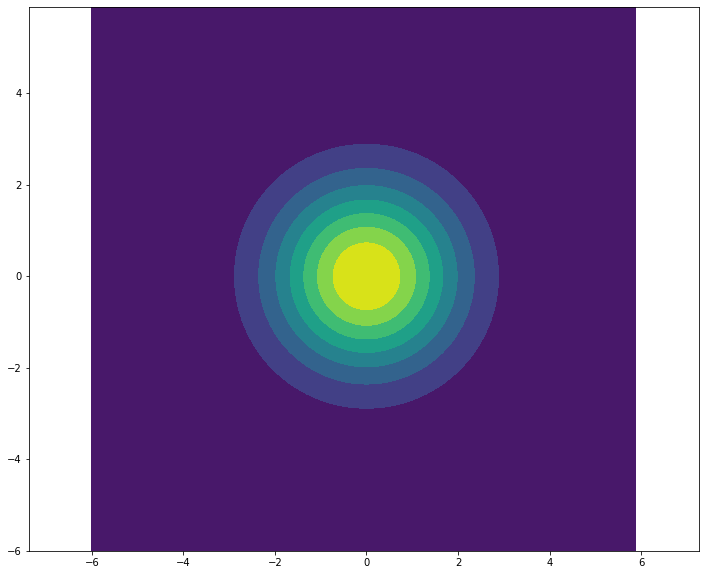

In [6]:
# The potential

V0 = 2*exp(-(xgrid**2 + ygrid**2)/4)

figsize(12, 10)
contourf(xx, xx, V0)
_ = axis('equal')

In [8]:
# The Birmann Schwinger operator

def get_K(λ, V = V0):
    Dirac_m1 = get_Dirac_inverse(Nb, λ)

    def mult_op(phi):
        sqrtV = zeros(2*Nb**2)
        sqrtV[up] = reshape(V**(1/2), Nb**2)
        sqrtV[down] = reshape(V**(1/2), Nb**2)

        phi1 = sqrtV*phi
        phi2 = Dirac_m1@phi1
        phi3 = sqrtV*phi2
        return phi3
    
    return LA.LinearOperator((2*Nb**2, 2*Nb**2), matvec = mult_op)

In [9]:
# Compute eigenvalues on a grid
Nλ = 100
λλ = linspace(-0.99, 0.99, Nλ) # the essential gap is [-1, 1]

Neigs = 10 # number of eigenvalues to compute

eig_pos = zeros((Nλ, Neigs))
eig_neg = zeros((Nλ, Neigs))

for iλ in range(Nλ):
    λ = λλ[iλ]
    K = get_K(λ)
    eig_pos[iλ, :], _ = LA.eigsh(K, k=Neigs, which='LA') # Neigs largest eigenvalues
    eig_neg[iλ, :], _ = LA.eigsh(K, k=Neigs, which='SA') # Neigs lowest eigenvalues

(-2.0, 2.0)

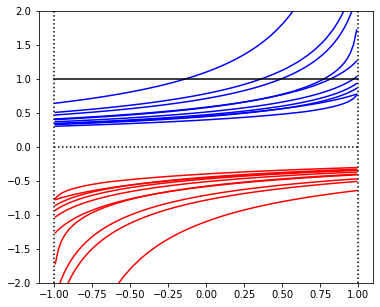

In [10]:
# Plot the spectrum of KV as a function of λ

figsize(6, 5)

plot(λλ, eig_pos, 'b')
plot(λλ, eig_neg, 'r')

plot([-1, 1], [1, 1], 'k')

plot([1, 1], [-2, 2], ':k')
plot([-1, -1], [-2, 2], ':k')
plot([-1, 1], [0, 0], ':k')

ylim([-2, 2])

#savefig("../spectrum_K_Dirac.png", bbox_inches='tight')

The points $\lambda$ where one of the blue curves touches the black one ($E = 1$) correspond to the eigenvalues of $D_m - V$.

## Same computation with Laplace operator

In [12]:
#########################################
def get_Laplacian_inverse(Nb, λ = -1):
    # returns the operator ((-\Delta) - λ)^{-1}
    # λ is negative

    KF = pi/a* roll( arange(-Nb//2+1, Nb//2+1), Nb//2 +1) # Fourier modes (with the correct shift)
    Kx, Ky = meshgrid(KF, KF)

    def mult_Laplace_m1(w):
        w_fft = fft.fft2( reshape(w, (Nb, Nb)) )
        res_fft = w_fft/(Kx**2 + Ky**2 - λ)
        res = reshape( fft.ifft2(res_fft) , Nb**2 )
        return res
    
    return LA.LinearOperator((Nb**2, Nb**2), matvec = mult_Laplace_m1)

In [11]:
def get_tildeK(λ, V = V0):
    Laplace_m1 = get_Laplacian_inverse(Nb, λ)

    def mult_op(phi):
        sqrtV = reshape(V**(1/2), Nb**2)

        phi1 = sqrtV*phi
        phi2 = Laplace_m1@phi1
        phi3 = sqrtV*phi2
        return phi3
    
    return LA.LinearOperator( (Nb**2, Nb**2), matvec = mult_op)

In [13]:
# Compute eigenvalues on a grid
Nλ = 100
λλ = linspace(-2, -0.01, Nλ) # we now take λ ∈ [-2, 0)

Neigs = 10
eigval = zeros((Nλ, Neigs))

for iλ in range(Nλ):
    λ = λλ[iλ]
    tildeK = get_tildeK(λ)
    eig, _ =  LA.eigsh(tildeK, k=Neigs, which='LA')
    eigval[iλ, :] = sort(eig)

(-2.0, 2.0)

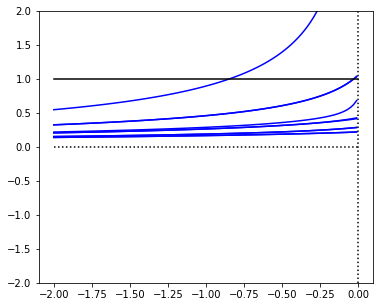

In [14]:
# Plot the spectrum of \tilde{KV} as a function λ

figsize(6, 5)
plot(λλ, eigval, 'b')

plot([-2, 0], [1, 1], 'k')
plot([0, 0], [-2, 2], ':k')
plot([-2, 0], [0, 0], ':k')

ylim([-2, 2])
#savefig("../spectrum_K_Laplace.png", bbox_inches='tight')